## Note
This notebook implements the previous quantization matrix estimation method using `torchjpeg`. To understand this notebook, go through `estimate_jpeg_qtable.ipynb` notebook first.

## Imports and settings

In [1]:
import numpy as np
from PIL import Image
import time
import io
import jpeglib
import torchjpeg.codec
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor
from fast_histogram import histogram1d

In [2]:
q_table_luminance = np.array([
    [16,  11,  10,  16,  24,  40,  51,  61],
    [12,  12,  14,  19,  26,  58,  60,  55],
    [14,  13,  16,  24,  40,  57,  69,  56],
    [14,  17,  22,  29,  51,  87,  80,  62],
    [18,  22,  37,  56,  68, 109, 103,  77],
    [24,  35,  55,  64,  81, 104, 113,  92],
    [49,  64,  78,  87, 103, 121, 120, 101],
    [72,  92,  95,  98, 112, 100, 103,  99]
])

def scale_q_table(q_table, q_factor):
    if q_factor <= 0:
        q_factor = 1
    if q_factor > 100:
        q_factor = 100

    if q_factor < 50:
        scale_factor = 5000 / q_factor
    else:
        scale_factor = 200 - q_factor * 2
    
    scaled_table = (q_table * scale_factor + 50) // 100
    scaled_table[scaled_table <= 0] = 1  # prevent zero division
    return scaled_table


In [3]:
# ref: https://github.com/getsanjeev/compression-DCT/blob/master/zigzag.py

# Zigzag scan of a matrix
# Argument is a two-dimensional matrix of any size,
# not strictly a square one.
# Function returns a 1-by-(m*n) array,
# where m and n are sizes of an input matrix,
# consisting of its items scanned by a zigzag method.

def zigzag(input):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    
    i = 0

    output = np.zeros(( vmax * hmax), dtype=int)
    #----------------------------------

    while ((v < vmax) and (h < hmax)):
        
        if ((h + v) % 2) == 0:                 # going up
            
            if (v == vmin):
                output[i] = input[v, h]        # if we got to the first line

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                output[i] = input[v, h] 
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                #print(3)
                output[i] = input[v, h] 
                v = v - 1
                h = h + 1
                i = i + 1
        
        else:                                    # going down

            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                output[i] = input[v, h] 
                h = h + 1
                i = i + 1
        
            elif (h == hmin):                  # if we got to the first column
                output[i] = input[v, h] 

                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1

                i = i + 1

            elif ((v < vmax -1) and (h > hmin)):     # all other cases
                output[i] = input[v, h] 
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            output[i] = input[v, h] 
            break

    return output

col_idx, row_idx = np.meshgrid(np.arange(8),np.arange(8))
zigzag_row_idx = zigzag(row_idx)
zigzag_col_idx = zigzag(col_idx)

## Estimation algorithm

### Step by step breakdown

If we only consider the luminance channel (grayscale image), the only lossy step of the JPEG compression algorithm is the quantization of DCT coefficients by the quantization table. Hence, instead of actually compressing the image, we can simulate the lossy stage in JPEG compression by directly quantizing the DCT coefficients of the image. Hence, we don't need to save and load the image repeatedly, which removes IO operations and speeds up the algorithm.

1. **Get reference DCT coefficient histograms**
    1. Read in quantized DCT coefficients directly from file using `torchjpeg.codec.read_coefficients()`.
    2. Dequantize the coefficients by multiplying by the m-th quantization table
    3. Get histogram of the dequantized coefficients
2. **Compression simulation (problematic part)**
    1. Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.
    2. Spatial domain, blockify, level shift, do DCT transform to yield DCT coefficients
    3. Simulate compressions with n constant matrices using DCT coefficients
        1. Perform quantization with chosen constant quantization table. This procedure is lossy. 
        2. Dequantize coefficients by multiplying with the same constant quantization table.
        3. Repeat steps 2.C.a and 2.C.b with m-th quantization table
        4. After the "simulated" compressions (steps 2.C.a-c), compute the DCT coefficient histogram.
3. **DCT coefficient histogram comparison**

Since Step 2 is complex, we will go through this step by step below.

Use the same image as above:

In [4]:
img_1_path = 'raise_1k/r000da54ft.TIF'
im = Image.open(img_1_path).convert('L')

#### Crop image to break JPEG alignment
1. *Cropping image need to break JPEG blocks.* Hence, it needs to be done in the spatial domain. PIL read image, then crop.

In [5]:
def crop_leave4(im):
    return im.crop((4, 4, im.size[0]-4, im.size[1]-4))

patch = crop_leave4(im)
print(f"Shape before: {np.array(im).shape}")
print(f"Shape after:  {np.array(patch).shape}")

Shape before: (2848, 4288)
Shape after:  (2840, 4280)


#### Blockify pixels, level shift, and do Discrete Cosine Transform to yield DCT coefficients
1. ~~Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.~~
2. *Spatial domain, blockify*

Number of blocks is H/8 * W/8

In [6]:
2840/8 * 4280/8

189925.0

In [7]:
pixels = to_tensor(patch) * 255  # convert to range [0-255]
pixel_blocks = torchjpeg.dct.blockify(pixels.unsqueeze(0), 8)
pixel_blocks.size()

torch.Size([1, 1, 189925, 8, 8])

1. ~~Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.~~
2. ~~Spatial domain, blockify,~~ *level shift, do DCT transform to yield DCT coefficients*. This step is lossless.

Level shift is to subtract 128 from all pixel values according to the specifications in Annex A.3.1 [[ref](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)].

In [8]:
dct_blocks = torchjpeg.dct.block_dct(pixel_blocks - 128)
dct_blocks.size()

torch.Size([1, 1, 189925, 8, 8])

#### Simulate compressions (i.e. quantize and dequantize DCT coefficients)
1. ~~Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.~~
2. ~~Spatial domain, blockify, level shift, do DCT transform to yield DCT coefficients~~
3. Simulate compressions with DCT coefficients
    1. *Perform quantization with chosen constant quantization table. This procedure is lossy.*
    2. *Dequantize coefficients by multiplying with the same constant quantization table.*

In [9]:
constant = 7
constant_q_table = torch.ones((8,8)) * constant
quantized_dct_blocks = torch.round(dct_blocks / constant_q_table)  # lossy step
dequantized_dct_blocks = quantized_dct_blocks * constant_q_table

1. ~~Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.~~
2. ~~Spatial domain, blockify, level shift, do DCT transform to yield DCT coefficients~~
3. Simulate compressions with DCT coefficients
    1. ~~Perform quantization with chosen constant quantization table. This procedure is lossy.~~
    2. ~~Dequantize coefficients by multiplying with the same constant quantization table.~~
    3. *Repeat steps 2.C.a and 2.C.b with m-th quantization table*

In [10]:
mth_q_table = torch.from_numpy(scale_q_table(q_table_luminance, 75))
quantized_dct_blocks = torch.round(dequantized_dct_blocks / mth_q_table)  # lossy step
dequantized_dct_blocks = quantized_dct_blocks * mth_q_table

#### Compute DCT coefficient histogram using dequantized DCT blocks
1. ~~Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.~~
2. ~~Spatial domain, blockify, level shift, do DCT transform to yield DCT coefficients~~
3. ~~Simulate compressions with DCT coefficients~~
    1. ~~Perform quantization with chosen constant quantization table. This procedure is lossy.~~
    2. ~~Dequantize coefficients by multiplying with the same constant quantization table.~~
    3. *Repeat steps 2.C.a and 2.C.b with m-th quantization table*
    4. *After the "simulated" compressions (steps 2.C.a-b), compute the DCT coefficient histogram.*

In [11]:
dequantized_dct_blocks.size()

torch.Size([1, 1, 189925, 8, 8])

In [12]:
np.array(dequantized_dct_blocks.squeeze()).reshape(-1, 64).transpose().shape

(64, 189925)

Generate 64 histograms, 1 for each k-factor

In [13]:
k_factor_list = np.array(dequantized_dct_blocks.squeeze()).reshape(-1, 64).transpose()

bin_range = 100
histograms = []
bins = []
stime = time.time()

for k in k_factor_list:
    # bin_range+2 since right most is excluded, ref: https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work
    h, b = np.histogram(k, bins=np.arange(-bin_range,bin_range+2))
    histograms.append(h)
    bins.append(b)
print(f"Took {time.time() - stime} seconds to compute.")

Took 1.7887487411499023 seconds to compute.


#### Side-track to test histogram computation speeds

The bottle-neck in the computation is in computing the histograms. The number of datapoints is large (~200k) depending on the image size. Test out speed and correctness of histogram computation using another package [fast-histogram](https://github.com/astrofrog/fast-histogram).

In [14]:
k_factor_list = np.array(dequantized_dct_blocks.squeeze()).reshape(-1, 64).transpose()

bin_range = 100
histograms = []
stime = time.time()

for k in k_factor_list:
    # bin_range+2 since right most is excluded, ref: https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work
    h, _ = np.histogram(k, bins=np.arange(-bin_range,bin_range+2))
    histograms.append(h)
print(f"Took {time.time() - stime} seconds to compute.")

Took 1.72157883644104 seconds to compute.


In [15]:
k_factor_list = np.array(dequantized_dct_blocks.squeeze()).reshape(-1, 64).transpose()

bin_range = 100
histograms_fast = []
stime = time.time()

for k in k_factor_list:
    h = histogram1d(k, bins=bin_range*2+1, range=(-bin_range,bin_range+1))
    histograms_fast.append(h)
print(f"Took {time.time() - stime} seconds to compute.")

Took 0.6873688697814941 seconds to compute.


In [16]:
np.all((np.array(histograms_fast) - np.array(histograms)) == 0)

True

### Full algorithm

In [4]:
def crop_leave4(im):
    return im.crop((4, 4, im.size[0]-4, im.size[1]-4))

def chi2_hist_distance(h1, h2):
    distance = 0
    for b in range(len(h1)):
        if h1[b] == 0 and h2[b] == 0:
            continue
        distance += (h1[b] - h2[b])**2 / (h1[b] + h2[b])
 
    return distance

def get_closest_histogram(reference, histogram_list):
    smallest_dist = np.inf
    smallest_idx = -1
    closest_hist = None
    
    for idx, h in enumerate(histogram_list):
        dist = chi2_hist_distance(h, reference)
        
        if dist < smallest_dist:
            smallest_dist = dist
            smallest_idx = idx
            closest_hist = h
    
    return closest_hist, smallest_idx

def compute_dct_coefficient_histogram(dct_blocks, bin_range=50):
    k_factor_list = dct_blocks.reshape(-1, 64).transpose()
    
    histograms = []
    for k in k_factor_list:
        h = histogram1d(k, bins=bin_range*2+1, range=(-bin_range,bin_range+1))
        histograms.append(h)

    return np.array(histograms)

def compression_simulation(im, n, mth_q_table, bin_range=100):
    """
    1. Cropping image need to break JPEG blocks. Hence, it needs to be done in the spatial domain. PIL read image, then crop.
    2. Spatial domain, blockify, level shift, do DCT transform to yield DCT coefficients
    3. Simulate compressions with n constant matrices using DCT coefficients
        1. Perform quantization with chosen constant quantization table. This procedure is lossy. 
        2. Dequantize coefficients by multiplying with the same constant quantization table.
        3. Repeat steps 2.C.a and 2.C.b with m-th quantization table
        4. After the "simulated" compressions (steps 2.C.a-b), compute the DCT coefficient histogram.
    
    Args:
        im: PIL image.
        n: Number of constant matrices to try.
        mth_q_table: Quantization table used in the m-th compression.
    Returns:
        List of list of histograms, of shape (64, n, histogram_size). 
    """
    ############################################
    # Step 1: Crop image to break JPEG block alignment
    ############################################
    patch = crop_leave4(im)

    ############################################
    # Step 2: Blockify, level shift and DCT transform
    ############################################
    pixels = (to_tensor(patch) * 255) - 128  # convert to range [0-255] and level shift
    pixel_blocks = torchjpeg.dct.blockify(pixels.unsqueeze(0), 8)
    dct_blocks = torchjpeg.dct.block_dct(pixel_blocks)
    
    ############################################
    # Step 3: Create n constant matrices and do compression (quantize and dequantize)
    ############################################
    k_hists_compare = []
    
    for i in range(1, n+1):
        # Create constant matrix with element i
        # M_i is just a length 64 constant array since jpeg compress takes in a 1d array
        M_i = torch.ones((8,8)) * i
        
        ############################################
        # Step 3.1 & 3.2: "Compress" using M_i
        ############################################
        quantized_dct_blocks = torch.round(dct_blocks / M_i)  # lossy step
        dequantized_dct_blocks = quantized_dct_blocks * M_i
        
        ############################################
        # Step 3.3: "Compress" again using mth_q_table
        ############################################
        quantized_dct_blocks = torch.round(dequantized_dct_blocks / mth_q_table)  # lossy step
        dequantized_dct_blocks = quantized_dct_blocks * mth_q_table
        
        ############################################
        # Step 3.4: Compute 64 histograms from dequantized dct coefficients
        ############################################
        k_hists = compute_dct_coefficient_histogram(np.array(dequantized_dct_blocks.squeeze()), bin_range=bin_range)
        k_hists_compare.append(k_hists)
        
    k_hists_compare = np.array(k_hists_compare).transpose(1,0,2)
    return k_hists_compare

def estimate_q_table(im_path, n, bin_range):
    """
    Args:
        im_path: Path to m-compressed image. Assume image is grayscale only.
        n: Greatest value assumed by quantization factors
    """
    # Step 1: Compute reference k DCT histograms for m-compressed image    
    _, mth_q_table, quantized_dct_blocks_ref, _ = torchjpeg.codec.read_coefficients(im_path)
    dct_blocks_ref = np.array((quantized_dct_blocks_ref * mth_q_table).squeeze()).reshape(-1, 8, 8)
    stime = time.time()
    k_hists_ref = compute_dct_coefficient_histogram(dct_blocks_ref, bin_range=bin_range)
    
    # Step 2: Simulate compressions to get k factor histograms
    im = Image.open(im_path)
    k_hists_compare = compression_simulation(im, n, mth_q_table, bin_range=bin_range)
    
    # Step 3: Compute closest histogram using chi-square histogram distance
    estimation = np.zeros(64)
    for i in range(64):
        hist, idx = get_closest_histogram(k_hists_ref[i], k_hists_compare[i])
        best_n = idx + 1  # since n starts from 1
        estimation[i] = best_n
    
    return estimation.reshape((8,8))

### Test individual images

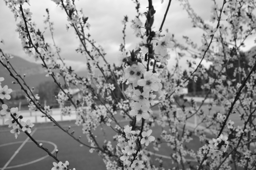

In [9]:
im_path = 'img_qf_70_90_1.jpg'
im = Image.open(im_path)
im.thumbnail((256,256))
im

In [10]:
stime = time.time()
est = estimate_q_table(im_path, 73, 100)
print(f"Took {time.time() - stime} seconds.")
est

Took 43.656022787094116 seconds.


array([[10.,  7.,  6., 10., 14., 24., 28., 68.],
       [ 7.,  7.,  8., 11., 16., 35., 31., 62.],
       [ 8.,  8., 10., 14., 24., 33., 36., 37.],
       [ 8., 10., 13., 17., 28., 70., 32., 48.],
       [11., 13., 21., 29., 36., 45.,  1., 29.],
       [14., 21., 32., 51., 45., 33.,  5., 40.],
       [27., 33., 41., 34.,  1.,  6.,  6., 10.],
       [58., 54., 50., 51., 10., 35.,  5.,  9.]])

In [11]:
scale_q_table(q_table_luminance, 70)

array([[10,  7,  6, 10, 14, 24, 31, 37],
       [ 7,  7,  8, 11, 16, 35, 36, 33],
       [ 8,  8, 10, 14, 24, 34, 41, 34],
       [ 8, 10, 13, 17, 31, 52, 48, 37],
       [11, 13, 22, 34, 41, 65, 62, 46],
       [14, 21, 33, 38, 49, 62, 68, 55],
       [29, 38, 47, 52, 62, 73, 72, 61],
       [43, 55, 57, 59, 67, 60, 62, 59]])

In [13]:
def zigzag_diff_first_n(q1, q2, n):
    return q1[zigzag_row_idx[:n], zigzag_col_idx[:n]] - q2[zigzag_row_idx[:n], zigzag_col_idx[:n]]

zigzag_diff_first_n(est, scale_q_table(q_table_luminance, 70), 15)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])